# RAGAS를 활용한 RAG 파라미터 비교 실험

## 목적
현업 표준 도구(RAGAS)로 RAG 파라미터 자동 평가

## RAGAS란?
**Retrieval Augmented Generation Assessment** - RAG 평가 업계 표준 프레임워크

| 메트릭 | 설명 | 평가 대상 |
|-------|------|----------|
| **Context Precision** | 검색된 문서 중 관련 있는 비율 | 검색 품질 |
| **Context Recall** | 필요한 정보를 다 가져왔는지 | 검색 커버리지 |

## 비교 설정
- chunk_size: 500 vs 1000
- chunk_overlap: 50 vs 200
- top_k: 3 vs 5

총 4개 조합 비교

---
## Part 1: 환경 설정

In [1]:
# 패키지 설치 (처음 한 번만 실행)
!pip install ragas pdfplumber -q

In [1]:
# 임포트 및 환경 설정
import os
import sys
import json
from pathlib import Path

# 프로젝트 루트 설정
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Windows 환경 호환성
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

print(f"프로젝트 루트: {project_root}")

프로젝트 루트: C:\workspace\enterprise-hr-agent


In [2]:
# 필수 라이브러리 임포트
import pdfplumber
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_ollama import ChatOllama

# RAGAS (reference 기반 메트릭 사용)
from ragas import evaluate, EvaluationDataset, SingleTurnSample
from ragas.metrics import ContextPrecision, ContextRecall
from ragas.llms import LangchainLLMWrapper
from ragas.run_config import RunConfig  # 타임아웃/병렬 설정

# 프로젝트 모듈
from core.llm.factory import create_embeddings

print("임포트 완료!")

C:\Users\82109\miniconda3\envs\hr\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3272\4003210671.py:10: DeprecationWarning: Importing ContextPrecision from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import ContextPrecision
  from ragas.metrics import ContextPrecision, ContextRecall
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3272\4003210671.py:10: DeprecationWarning: Importing ContextRecall from 'ragas.metrics' is deprecated and will be removed in v1.0. Please use 'ragas.metrics.collections' instead. Example: from ragas.metrics.collections import ContextRecall
  from ragas.metrics import ContextPrecision, ContextRecall


임포트 완료!


---
## Part 2: 데이터 준비

In [3]:
# PDF 로드
pdf_path = project_root / "data/company_docs/02_회사규정.pdf"

documents = []
with pdfplumber.open(str(pdf_path)) as pdf:
    for i, page in enumerate(pdf.pages):
        text = page.extract_text()
        if text:
            documents.append(Document(page_content=text, metadata={"page": i + 1}))

print(f"총 {len(documents)} 페이지 로드")

총 48 페이지 로드


In [4]:
# 테스트 케이스 로드
test_file = project_root / "data/finetuning/rag_test.json"

with open(test_file, "r", encoding="utf-8") as f:
    test_cases = json.load(f)

print(f"테스트 케이스: {len(test_cases)}개")
print(f"\n예시: {test_cases[0]['question']}")

테스트 케이스: 10개

예시: 병가는 어떻게 사용하나요?


---
## Part 3: 파라미터별 인덱스 생성

In [5]:
# 청킹 및 인덱스 생성 함수
def create_index(documents, chunk_size, overlap, embeddings):
    """
    문서를 청킹하고 FAISS 인덱스 생성
    
    Args:
        documents: 원본 문서 리스트
        chunk_size: 청크 크기 (글자 수)
        overlap: 청크 간 겹침 (글자 수)
        embeddings: 임베딩 모델
    
    Returns:
        vectorstore: FAISS 인덱스
        chunk_count: 생성된 청크 수
    """
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = splitter.split_documents(documents)
    vectorstore = FAISS.from_documents(chunks, embeddings)
    return vectorstore, len(chunks)

In [6]:
# 임베딩 모델 초기화 (로컬 Ollama)
embeddings = create_embeddings(
    provider="ollama",
    model="snowflake-arctic-embed2",
    base_url="http://localhost:11434"
)

print("임베딩 모델 초기화 완료")

임베딩 모델 초기화 완료


In [7]:
# 비교할 설정 정의
configs = [
    {"name": "현재 (500/50)", "chunk_size": 500, "overlap": 50},
    {"name": "권장 (1000/200)", "chunk_size": 1000, "overlap": 200},
]

# 설정별 인덱스 생성
indices = {}
for config in configs:
    vs, chunk_count = create_index(
        documents, 
        config["chunk_size"], 
        config["overlap"], 
        embeddings
    )
    indices[config["name"]] = vs
    print(f"{config['name']}: {chunk_count} 청크 생성")

현재 (500/50): 147 청크 생성
권장 (1000/200): 91 청크 생성


---
## Part 4: RAGAS 평가 (핵심!)

RAGAS는 LLM을 사용해 검색 품질을 평가합니다.
- **Context Precision**: 검색된 문서가 질문과 관련 있는지
- **Context Recall**: 정답에 필요한 정보를 모두 검색했는지

In [8]:
# RAGAS 평가자 LLM 설정 (로컬 Ollama)
# timeout 증가: 기본값이 너무 짧아서 타임아웃 발생
llm = ChatOllama(
    model="qwen3:8b", 
    base_url="http://localhost:11434",
    temperature=0,  # 일관된 평가를 위해 0으로 설정
    timeout=120  # 타임아웃 2분으로 증가
)
evaluator_llm = LangchainLLMWrapper(llm)

print("평가자 LLM 초기화 완료 (qwen3:8b, timeout=120s)")

평가자 LLM 초기화 완료 (qwen3:8b, timeout=120s)


C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_3272\45345645.py:9: DeprecationWarning: LangchainLLMWrapper is deprecated and will be removed in a future version. Use llm_factory instead: from openai import OpenAI; from ragas.llms import llm_factory; llm = llm_factory('gpt-4o-mini', client=OpenAI(api_key='...'))
  evaluator_llm = LangchainLLMWrapper(llm)


In [9]:
# RAGAS 평가 메트릭 정의 (reference 기반)
# ContextPrecision: 검색된 문서가 정답과 관련 있는지
# ContextRecall: 정답에 필요한 정보를 모두 검색했는지
metrics = [
    ContextPrecision(llm=evaluator_llm),
    ContextRecall(llm=evaluator_llm),
]

print("평가 메트릭:")
for m in metrics:
    print(f"  - {m.name}")

평가 메트릭:
  - context_precision
  - context_recall


In [10]:
# RAGAS 평가 함수
# Ollama용 RunConfig: 병렬 처리 줄이고 타임아웃 늘리기
run_config = RunConfig(
    max_workers=2,   # Ollama는 순차 처리가 안정적 (너무 1이면 느림)
    timeout=180      # 타임아웃 3분
)

def evaluate_with_ragas(vectorstore, test_cases, top_k, metrics):
    """
    RAGAS로 검색 품질 평가
    
    Args:
        vectorstore: FAISS 인덱스
        test_cases: 테스트 케이스 리스트
        top_k: 검색할 문서 수
        metrics: RAGAS 메트릭 리스트
    
    Returns:
        평가 결과 딕셔너리
    """
    samples = []
    
    for case in test_cases:
        # 유사도 검색
        docs = vectorstore.similarity_search(case["question"], k=top_k)
        contexts = [d.page_content for d in docs]
        
        # RAGAS 샘플 생성
        sample = SingleTurnSample(
            user_input=case["question"],
            retrieved_contexts=contexts,
            reference=case["ground_truth"]
        )
        samples.append(sample)
    
    # 평가 실행 (RunConfig 적용)
    dataset = EvaluationDataset(samples=samples)
    result = evaluate(dataset=dataset, metrics=metrics, run_config=run_config)
    
    return result

print(f"RunConfig 설정: max_workers={run_config.max_workers}, timeout={run_config.timeout}s")

RunConfig 설정: max_workers=2, timeout=180s


In [11]:
%%time
# 모든 설정 조합 평가 (시간 소요: ~10분)
print("RAGAS 평가 시작 (약 10분 소요)...\n")

def get_score(result, metric_name):
    """결과에서 점수 추출 (리스트면 평균, 숫자면 그대로)"""
    value = result[metric_name]
    if isinstance(value, list):
        # NaN 제외하고 평균 계산
        valid = [v for v in value if v is not None and v == v]  # v == v로 NaN 체크
        return sum(valid) / len(valid) if valid else 0
    return value

results = {}
top_k_values = [3, 5]

for name, vectorstore in indices.items():
    for top_k in top_k_values:
        key = f"{name}, k={top_k}"
        print(f"평가 중: {key}...")
        
        try:
            result = evaluate_with_ragas(vectorstore, test_cases, top_k, metrics)
            results[key] = result
            
            # 결과 출력
            precision = get_score(result, 'context_precision')
            recall = get_score(result, 'context_recall')
            print(f"  Context Precision: {precision:.3f}")
            print(f"  Context Recall: {recall:.3f}")
            print()
        except Exception as e:
            print(f"  에러: {e}")
            results[key] = None

print("평가 완료!")

RAGAS 평가 시작 (약 10분 소요)...

평가 중: 현재 (500/50), k=3...


Evaluating: 100%|███████████████████████████████████████████████████| 20/20 [05:18<00:00, 15.94s/it]


  Context Precision: 0.558
  Context Recall: 0.800

평가 중: 현재 (500/50), k=5...


Evaluating: 100%|███████████████████████████████████████████████████| 20/20 [07:00<00:00, 21.02s/it]


  Context Precision: 0.553
  Context Recall: 1.000

평가 중: 권장 (1000/200), k=3...


Evaluating: 100%|███████████████████████████████████████████████████| 20/20 [05:15<00:00, 15.76s/it]


  Context Precision: 0.692
  Context Recall: 0.900

평가 중: 권장 (1000/200), k=5...


Evaluating:  35%|██████████████████▏                                 | 7/20 [03:02<05:25, 25.04s/it]Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt context_recall_classification_prompt failed to parse output: The output parser failed to parse the output including retries.
Exception raised in Job[7]: RagasOutputParserException(The output parser failed to parse the output including retries.)
Evaluating:  85%|███████████████████████████████████████████▎       | 17/20 [07:27<01:32, 30.67s/it]Prompt fix_output_format failed to parse output: The output parser failed to parse the output including retries.
Prompt fix_output_format failed to parse output: The output parser failed to parse the output in

  Context Precision: 0.702
  Context Recall: 1.000

평가 완료!


---
## Part 5: 결과 비교

In [12]:
# 결과 테이블 생성
import pandas as pd

def get_score(result, metric_name):
    """결과에서 점수 추출 (리스트면 평균, 숫자면 그대로)"""
    value = result[metric_name]
    if isinstance(value, list):
        valid = [v for v in value if v is not None and v == v]
        return sum(valid) / len(valid) if valid else 0
    return value

rows = []
for key, result in results.items():
    if result is not None:
        precision = get_score(result, 'context_precision')
        recall = get_score(result, 'context_recall')
        rows.append({
            "설정": key,
            "Context Precision": precision,
            "Context Recall": recall,
            "평균": (precision + recall) / 2
        })

df = pd.DataFrame(rows)
df = df.sort_values("평균", ascending=False)

print("=" * 60)
print("RAGAS 평가 결과")
print("=" * 60)
print(df.to_string(index=False))

RAGAS 평가 결과
                설정  Context Precision  Context Recall       평균
권장 (1000/200), k=5           0.702361             1.0 0.851181
권장 (1000/200), k=3           0.691667             0.9 0.795833
  현재 (500/50), k=5           0.552917             1.0 0.776458
  현재 (500/50), k=3           0.558333             0.8 0.679167


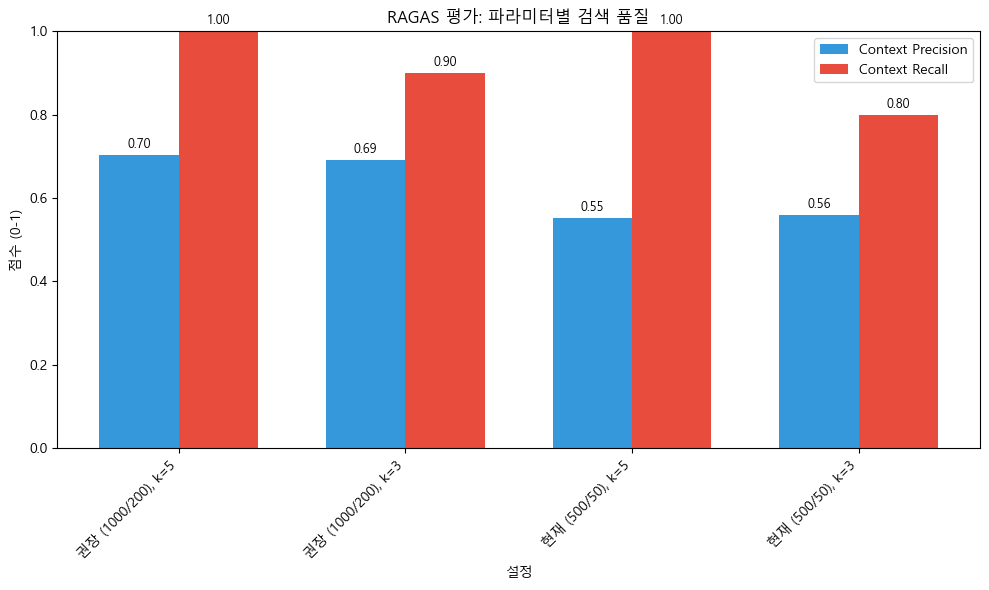

In [13]:
# 시각화
import matplotlib.pyplot as plt

# 한글 폰트 설정 (Windows)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 바 차트
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], df["Context Precision"], width, 
               label="Context Precision", color="#3498db")
bars2 = ax.bar([i + width/2 for i in x], df["Context Recall"], width,
               label="Context Recall", color="#e74c3c")

ax.set_xlabel("설정")
ax.set_ylabel("점수 (0-1)")
ax.set_title("RAGAS 평가: 파라미터별 검색 품질")
ax.set_xticks(x)
ax.set_xticklabels(df["설정"], rotation=45, ha="right")
ax.legend()
ax.set_ylim(0, 1)

# 값 표시
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

In [14]:
# 최적 설정 도출
best_idx = df["평균"].idxmax()
best = df.loc[best_idx]

print("=" * 60)
print("최적 설정 (RAGAS 기준)")
print("=" * 60)
print(f"설정: {best['설정']}")
print(f"Context Precision: {best['Context Precision']:.3f}")
print(f"Context Recall: {best['Context Recall']:.3f}")
print(f"평균 점수: {best['평균']:.3f}")

최적 설정 (RAGAS 기준)
설정: 권장 (1000/200), k=5
Context Precision: 0.702
Context Recall: 1.000
평균 점수: 0.851


In [15]:
# 결과 저장
output = {
    "results": [],
    "best_config": {
        "name": best["설정"],
        "context_precision": best["Context Precision"],
        "context_recall": best["Context Recall"],
        "avg_score": best["평균"]
    }
}

for _, row in df.iterrows():
    output["results"].append({
        "config": row["설정"],
        "context_precision": row["Context Precision"],
        "context_recall": row["Context Recall"],
        "avg_score": row["평균"]
    })

output_path = project_root / "data/finetuning/ragas_evaluation_results.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(output, f, ensure_ascii=False, indent=2)

print(f"결과 저장: {output_path}")

결과 저장: C:\workspace\enterprise-hr-agent\data\finetuning\ragas_evaluation_results.json


---
## 결론

### 평가 방법 비교

| 항목 | 키워드 매칭 (이전) | RAGAS (현업 표준) |
|-----|------------------|------------------|
| 평가 방식 | 문자열 포함 여부 | LLM 기반 의미 평가 |
| 메트릭 | 1개 (매칭률) | 2개+ (Precision, Recall) |
| 정확도 | 낮음 | 높음 |
| 현업 사용 | X | O |

### 면접 답변 요점

> "RAG 파라미터는 **RAGAS 프레임워크로 Grid Search** 방식으로 최적화했습니다.  
> chunk_size(500/1000), overlap(50/200), top_k(3/5) 조합을 테스트하여  
> **Context Precision과 Context Recall** 기준으로 최적 설정을 선택했습니다."